In [1]:
import numpy as np
from mpnet.sst_envs.utils import load_data, get_obs_3d
import pickle
import time
import click
from tqdm.auto import tqdm
from pathlib import Path
import importlib
from matplotlib import pyplot as plt

import sys
sys.path.append('/media/arclabdl1/HD1/Linjun/mpc-mpnet-py/deps/sparse_rrt-1')

from sparse_rrt import _deep_smp_module
# from params.cpp_dst_s32_e4 import get_params

def experiment_vis(env_id, traj_id, verbose=False, system='quadrotor_obs', params=None, number_of_iterations=1):
    print("env {}, traj {}".format(env_id, traj_id))
    obs_list = get_obs_3d(system, env_id)[env_id].reshape(-1, 3)
    data = load_data(system, env_id, traj_id)
    ref_path = data['path']
    start_goal = data['start_goal']
    # print(start_goal)
    env_vox = np.load('mpnet/sst_envs/data/{}_env_vox.npy'.format(system))
    obc = env_vox[env_id]
    print(obc.shape)
    # print(obs_list)
    params = params
    #number_of_iterations = params['number_of_iterations'] #3000000# 
    min_time_steps = params['min_time_steps'] if 'min_time_steps' in params else 80
    max_time_steps = params['max_time_steps'] if 'min_time_steps' in params else 400
    integration_step = params['dt']
    

    planner = _deep_smp_module.DSSTMPCWrapper(
        system_type=system,
        start_state=np.array(ref_path[0]),
    #             goal_state=np.array(ref_path[-1]),
        goal_state=np.array(data['start_goal'][-1]),
        goal_radius=params['goal_radius'],
        random_seed=0,
        sst_delta_near=params['sst_delta_near'],
        sst_delta_drain=params['sst_delta_drain'],
        obs_list=obs_list,
        width=params['width'],
        verbose=params['verbose'],
        mpnet_weight_path=params['mpnet_weight_path'], 
        cost_predictor_weight_path=params['cost_predictor_weight_path'],
        cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
        num_sample=params['cost_samples'],
        np=params['n_problem'], ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
        converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
        std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
        device_id=params['device_id'], refine_lr=params['refine_lr'],
        weights_array=params['weights_array'],
        obs_voxel_array=obc.reshape(-1)
    )
    return data, planner

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_line_3d(ax, p, p_index, color='b', alpha=1):
    for p_i in p_index:
        ax.plot3D(p[p_i, 0], p[p_i, 1], p[p_i, 2], c=color, alpha=alpha)

def centered_box_to_points_3d(center, size):
    half_size = [s/2 for s in size]
    direction, p = [1, -1], []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([center[di] + [x_d, y_d, z_d][di] * half_size[0] for di in range(3)])
    return p

def rot_frame_3d(state, frame_size=0.25):
    b, c, d, a = state[3:7]
    rot_mat = np.array([[2 * a**2 - 1 + 2 * b**2, 2 * b * c + 2 * a * d, 2 * b * d - 2 * a * c],
                        [2 * b * c - 2 * a * d, 2 * a**2 - 1 + 2 * c**2, 2 * c * d + 2 * a * b],
                        [2 * b * d + 2 * a * c, 2 * c * d - 2 * a * b, 2 * a**2 - 1 + 2 * d**2]])
    quadrotor_frame = np.array([[frame_size, 0, 0],
                                 [0, frame_size, 0],
                                 [-frame_size, 0, 0],
                                 [0, -frame_size, 0]]).T
    quadrotor_frame = rot_mat @ quadrotor_frame + state[:3].reshape(-1, 1)
    return quadrotor_frame

def q_to_points_3d(state):
    quadrotor_frame = rot_frame_3d(state)   
    max_min, direction = [np.max(quadrotor_frame, axis=1), np.min(quadrotor_frame, axis=1)], [1, 0]
    p = []
    for x_d in direction:
        for y_d in direction:
            for z_d in direction:
                p.append([max_min[x_d][0], max_min[y_d][1], max_min[z_d][2]])
    return np.array(p)

def draw_box_3d(ax, p, color='b', alpha=1, surface_color='blue', linewidths=1, edgecolors='k'):
    index_lists = [[[0, 4], [4, 6], [6, 2], [2, 0], [0, 1], [1, 5], [5, 7], [7, 3], [3, 1], [1, 5]],
                  [[4, 5]],
                  [[6, 7]],
                  [[2, 3]]]
    for p_i in index_lists:
        draw_line_3d(ax, np.array(p), p_i, color=color, alpha=alpha)
    edges = [[p[e_i] for e_i in f_i] for f_i in [[0, 1, 5, 4],
                                                 [4, 5, 7, 6],
                                                 [6, 7, 3, 2],
                                                 [2, 0, 1, 3],
                                                 [2, 0, 4, 6],
                                                 [3, 1, 5, 7]]]
    faces = Poly3DCollection(edges, linewidths=linewidths, edgecolors=edgecolors)
    faces.set_facecolor(surface_color)
    faces.set_alpha(0.1)
    ax.add_collection3d(faces)


def visualize_quadrotor_path(path, start_state, goal_state, obs_list, fig=None, ax=None, draw_bbox=True, width=1, savefig=False):
    if ax is None or fig is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
    
    counter = 0

    for obs in obs_list:
        draw_box_3d(ax, centered_box_to_points_3d(center=obs, size=[width]*3))
    
    ax.scatter(start_state[0], start_state[1], start_state[2], c='red')
    ax.scatter(goal_state[0], goal_state[1], goal_state[2], c='orange')
    draw_box_3d(ax, q_to_points_3d(start_state), alpha=0.3, surface_color="orange", linewidths=0.)
    draw_box_3d(ax, q_to_points_3d(goal_state), alpha=0.3, surface_color="orange", linewidths=0.)
    
    if path is not None:
        ax.scatter(path[:, 0], path[:, 1], path[:, 2], c='blue')
        ax.plot(path[:, 0], path[:, 1], path[:, 2], c='blue')
        
        for waypoint in path:
            f = rot_frame_3d(waypoint)
            ax.scatter(f[0], f[1], f[2], color='red', s=10)
            ax.plot(f[0,[0, 2]], f[1, [0, 2]], f[2, [0, 2]], c='b')
            ax.plot(f[0,[1, 3]], f[1, [1, 3]], f[2, [1, 3]], c='b')

            if draw_bbox:
                draw_box_3d(ax, q_to_points_3d(waypoint), alpha=0.3, surface_color="orange", linewidths=0.)
    
            ax.set_xlim3d(-5, 5)
            ax.set_ylim3d(-5, 5)
            ax.set_zlim3d(-5, 5)
            if savefig:
                fig.savefig("figs/{}.png".format(counter))
            counter += 1
    
    return fig, ax

In [3]:
env_id = 0
traj_id = 900
system = 'quadrotor_obs'
config = 'default'
params = {
        'n_problem': 1,
        'n_sample': 32,
        'n_elite': 4,
        'n_t': 2,
        'max_it': 5,
        'converge_r': 1e-10,

        'dt': 2e-3,

        'mu_u': [-10, 0, 0, 0],
        'sigma_u': [15, 1, 1, 1],

        'mu_t': 0.3,
        'sigma_t': 0.5,
        't_max': 1,

        'verbose':  False,#True,#
        'step_size': 1,

        "goal_radius": 2,

        "sst_delta_near": .1,
        "sst_delta_drain": 0.,
        "goal_bias": 0.05,

        "width": 1,
        "hybrid": False,
        "hybrid_p": 0.0,

        "cost_samples": 1,
        "mpnet_weight_path":"mpnet/exported/output/quadrotor_obs/mpnet.pt",
        "cost_predictor_weight_path": "",
        "cost_to_go_predictor_weight_path": "",

        "refine": False,
        "using_one_step_cost": False,
        "refine_lr": 0.,
        "refine_threshold": 0.,
        "device_id": "cuda:2",

        "cost_reselection": False,
        "number_of_iterations": 100,
        "weights_array": np.ones(13),
        "shm_max_steps": 100,
        'max_planning_time': 500,
    }


def visualize_pair(start, sample, actual, ax=plt):
    # for state
    ax.scatter(start[0], start[1], start[2], c='blue')
    ax.scatter(sample[0], sample[1], sample[2], c='skyblue')
    ax.plot([start[0], sample[0]], [start[1], sample[1]], [start[2], sample[2]], color='skyblue')
    
    ax.scatter(actual[0], actual[1], actual[2], c='green')
    ax.plot([start[0], actual[0]], [start[1], actual[1]], [start[2], actual[2]], color='lime')

env 0, traj 900
(32, 32, 32)


<IPython.core.display.Javascript object>


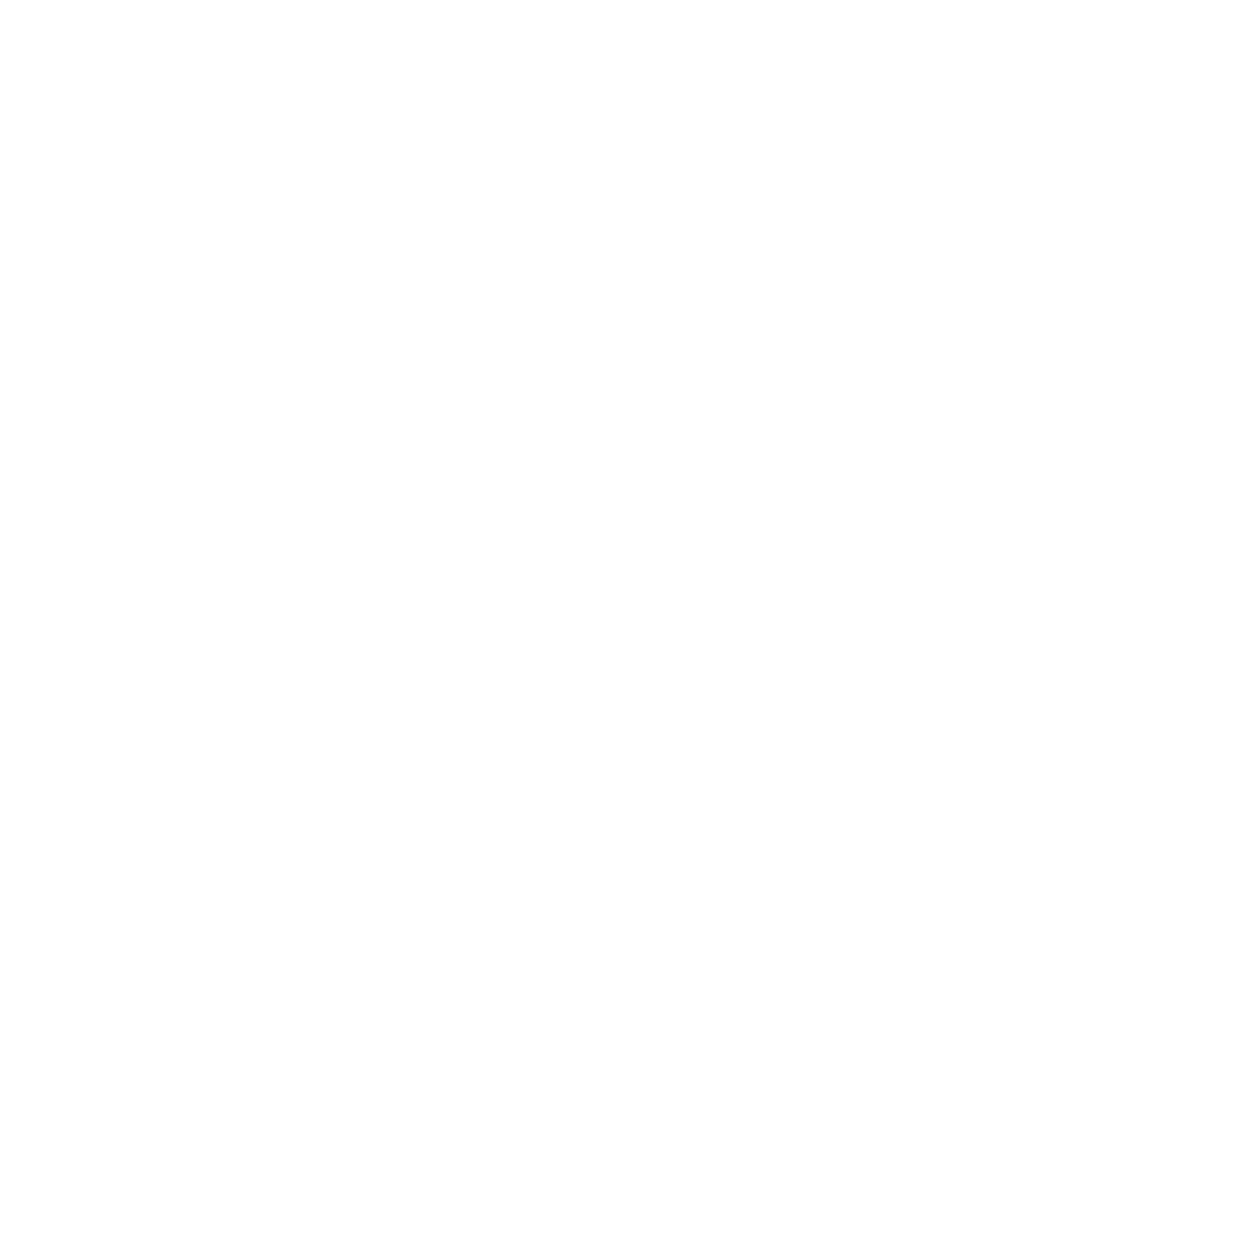

[-2.87494618  4.0512126   4.26753359  0.14212995  0.00691021  0.00698014
  0.98979962  0.03171255 -0.59613457  0.75674502  0.35172503  0.01710051
  0.01727355]
[-3.03405087  3.63218002  4.48036038  0.25371862  0.01471922 -0.23471258
  0.93825397 -0.57298834 -1.          1.          0.07307645  0.13317561
 -0.01396909]
[-2.93294142  2.94860878  4.79348431  0.14196768  0.24121245 -0.25566392
  0.92536385  1.         -1.          1.         -0.16175506  0.09794746
  0.22666914]
[-2.56261747  2.49460878  4.45775256  0.04765999  0.20446893 -0.15868467
  0.96474928  1.         -1.          0.10257054 -0.19019105 -0.11481561
  0.48527665]
[-2.00677143  1.93860878  4.99948961  0.13933022  0.00774949  0.08488255
  0.98657147  0.99014164 -1.          1.          0.15839092 -0.40772736
  0.47075126]
[-1.36423326  1.39021238  4.49015967 -0.08093321  0.05751082  0.37771775
  0.92058285  0.71964437 -0.23861655  0.22820687 -0.39322086  0.20367879
  0.48929822]
[-0.9754579   1.39402462  4.57164727 -0.

In [4]:
%matplotlib notebook

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='quadrotor_obs', 
                    params=params, 
                    number_of_iterations=params['number_of_iterations'])


ref_path = data['path']

# fig, ax =  visualize_quadrotor_path(ref_path, 
#                                     data['start_goal'][0],
#                                     data['start_goal'][-1], 
#                                     obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


state = np.repeat(np.array([ref_path[0].copy()]), params['n_problem'],  axis=0)

actual_path = []

full_time = 0
import time
for i in range(len(ref_path)-1):
    tic = time.perf_counter()
    state = np.repeat(np.array([ref_path[i].copy()]), params['n_problem'],  axis=0)
    sample =  np.repeat(np.array([ref_path[i+1].copy()]), params['n_problem'],  axis=0)
    actual_state = planner.steer_batch(state, sample, params['n_problem'])[0]
    print(actual_state)
    toc = time.perf_counter()
    time_cost = toc - tic
    full_time += time_cost
    actual_path.append(actual_state)
    state = np.repeat(np.array([actual_state.copy()]), params['n_problem'],  axis=0)#actual_state.copy()
print("total: {}".format(full_time))

actual_path = np.array(actual_path)

# ax.plot(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2])
# ax.scatter(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2])

ax.plot(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
ax.scatter(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])

env 0, traj 900
(32, 32, 32)


<IPython.core.display.Javascript object>


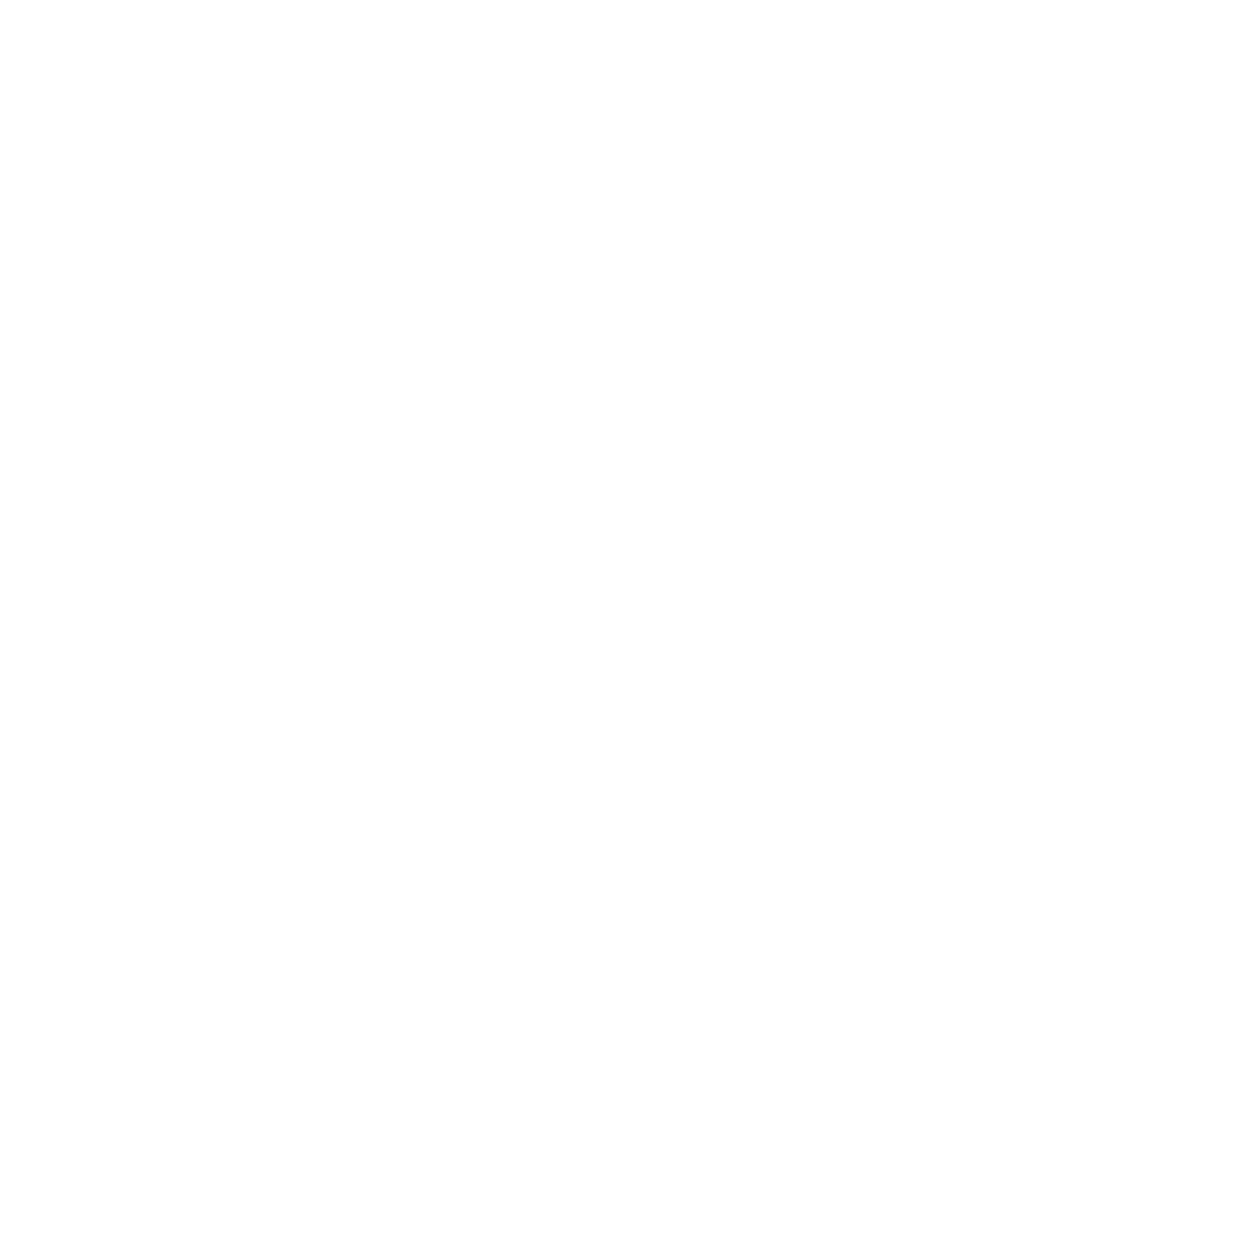

(-5.0, 5.0)

In [5]:
%matplotlib notebook

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='quadrotor_obs', 
                    params=params, 
                    number_of_iterations=params['number_of_iterations'])


ref_path = data['path']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


# state = np.repeat(np.array([ref_path[0].copy()]), params['n_problem'],  axis=0)
actual_state = ref_path[0].copy()

actual_path = []
samples = []

full_time = 0



import time
for i in range(len(ref_path)):
    start  = ref_path[i].astype(float).copy()
#     print(start)
    for j in range(1):
        sample = planner.neural_sample(start)
    #     print(sample)
        actual_state = planner.steer(start, sample)
    #     print(actual_state)
        actual_path.append(actual_state.copy())
        ax.plot([start[0], sample[0]], [start[1], sample[1]], [start[2], sample[2]], c='skyblue')
        ax.plot([start[0], actual_state[0]], [start[1], actual_state[1]], [start[2], actual_state[2]], c='green')

actual_path = np.array(actual_path)


ax.plot(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[0, 0], ref_path[0, 1], ref_path[0, 2], c='blue')

# ax.plot(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
# ax.scatter(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-5, 5)

env 0, traj 900
(32, 32, 32)


<IPython.core.display.Javascript object>


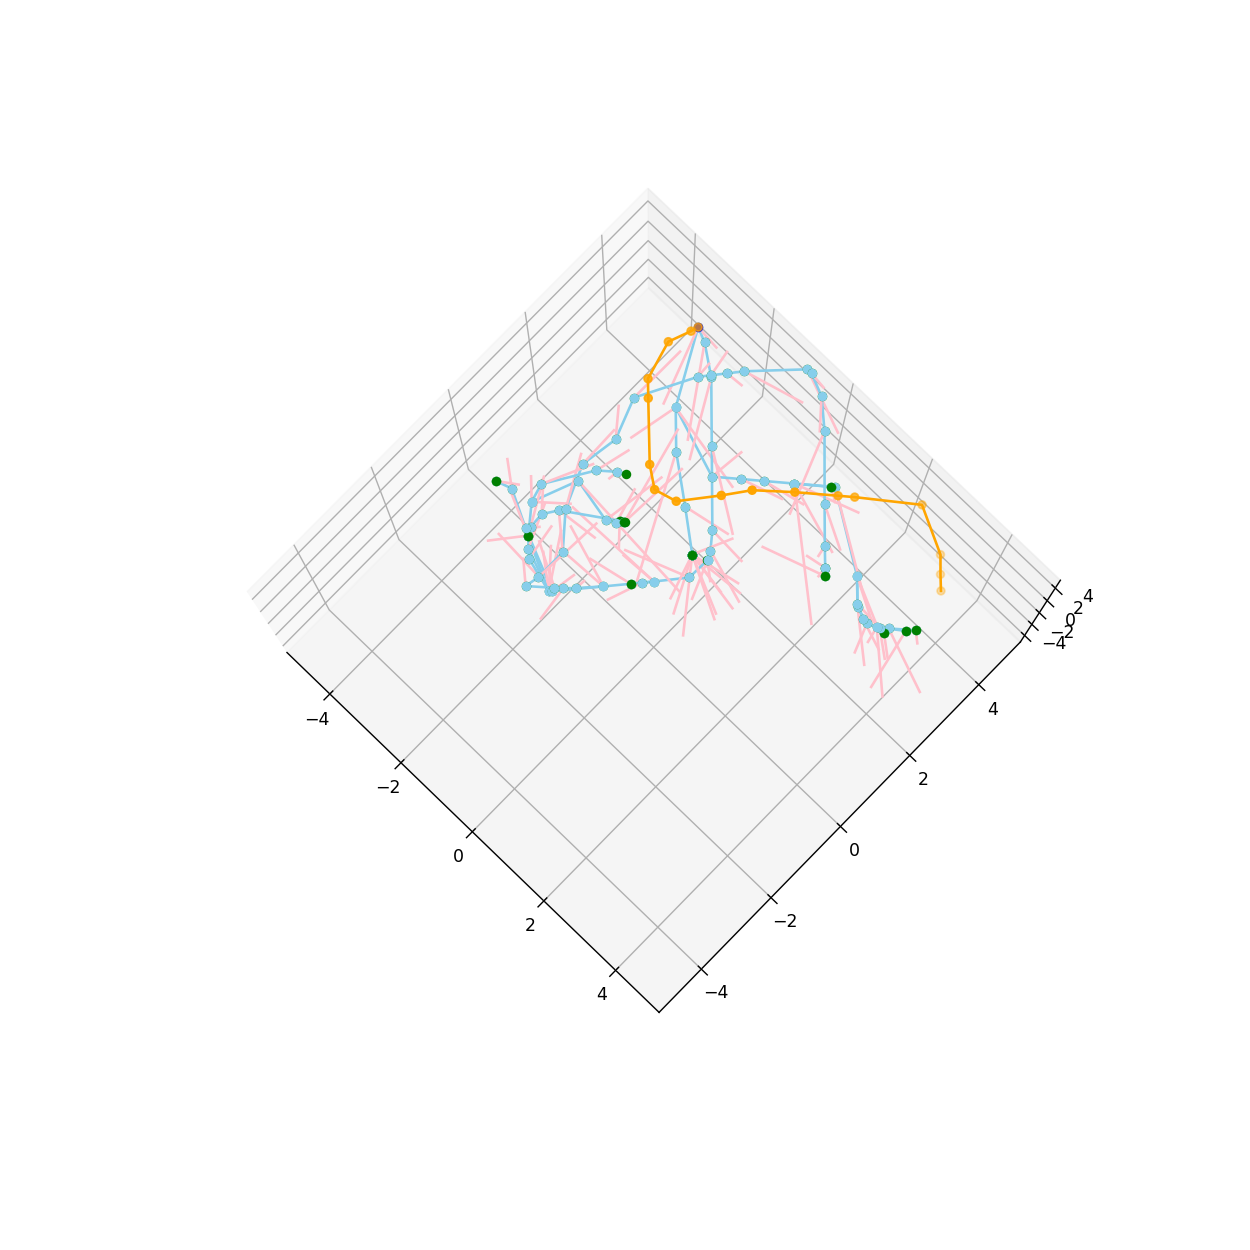

[-2.87958828  4.1408887   4.04748084  0.          0.          0.
  1.          0.          0.          0.          0.          0.
  0.         -2.1412938   2.78615436  3.92053291  0.50136258  0.38665496
  0.31863369  0.70541333  1.         -1.         -1.          0.07287074
  1.          0.85486369 -2.4063985   2.74204224  3.41633797  0.03638543
  0.10115846 -0.02569581  0.99387258  0.29856408 -0.18861517  0.10514045
  0.10532081  0.25053877 -0.11258447]
[-2.1412938   2.78615436  3.92053291  0.50136258  0.38665496  0.31863369
  0.70541333  1.         -1.         -1.          0.07287074  1.
  0.85486369 -0.8752938   2.45965345  2.65453291  0.15004362  0.78030223
  0.47319276  0.38040156  1.          1.         -1.         -0.69943138
  1.          0.41508833 -0.4392451   2.54980922  2.99070805  0.24395819
  0.68901139  0.20079961  0.65224785  1.08221138 -0.7579999  -0.81425238
 -0.10119966  0.35880637  0.44238383]
[-8.75293800e-01  2.45965345e+00  2.65453291e+00  1.50043621e-01
  7.803

[-0.51790739  0.53740357 -0.29251007  0.50752669  0.36258548 -0.74436702
  0.23846844 -1.         -1.         -1.         -0.24700451 -0.15452693
 -0.5050273  -1.20590739 -0.15059643 -0.97151314  0.35015965  0.1996978
 -0.89488921  0.1915272  -1.         -1.         -0.86940037  0.0377572
 -0.16024244 -0.51694745 -2.64570981  0.49515229 -0.35551079  0.23059462
  0.27598751 -0.91001731  0.2062175  -0.8740232  -0.90567183 -0.77802271
 -0.01710811 -0.02788029 -0.26147872]
[-1.20590739 -0.15059643 -0.97151314  0.35015965  0.1996978  -0.89488921
  0.1915272  -1.         -1.         -0.86940037  0.0377572  -0.16024244
 -0.51694745 -1.91790739 -0.85450772 -1.68073526  0.17975146 -0.03245705
 -0.96956182  0.1630545  -1.         -0.89403249 -1.         -0.11606341
 -0.46222665 -0.07657565 -2.38839239 -0.153003   -1.60992146  0.1582289
 -0.00361783 -0.94064367  0.30023363 -0.90047628 -0.88188827 -0.45539305
  0.06349665 -0.1349881  -0.50557703]
[-1.91790739 -0.85450772 -1.68073526  0.17975146 -0

[-2.66190739 -0.73179916 -1.40152293  0.05103473 -0.2613596  -0.95458948
  0.1335884  -1.          1.          1.         -0.20702697 -0.23588251
 -0.33032164 -2.95173692 -0.44179916 -1.11152293 -0.01026717 -0.2696464
 -0.95579429  0.1168026  -0.9904669   1.          1.         -0.21333696
 -0.07687378 -0.60098169 -2.75572151 -0.00446831 -1.05088539 -0.0729395
 -0.15584511 -0.94334     0.28372791 -0.89387411  0.94165176  0.70805013
 -0.13031787  0.17805123 -0.69061571]
[-2.95173692 -0.44179916 -1.11152293 -0.01026717 -0.2696464  -0.95579429
  0.1168026  -0.9904669   1.          1.         -0.21333696 -0.07687378
 -0.60098169 -3.32182902  0.04420084 -0.64039359 -0.04981874 -0.15423638
 -0.98252429  0.09151963 -0.46315736  1.          1.         -0.01406574
  0.37036687 -0.64338197 -3.62411767 -0.18410403  0.49854573 -0.09005184
 -0.13273171 -0.96934193  0.18614317 -0.36258829  0.92781472  1.11884689
 -0.31453606  0.14387128 -0.49163753]
[-3.32182902  0.04420084 -0.64039359 -0.04981874 -

[ 0.7387062   4.07365345  1.04053291  0.07751741  0.98061517  0.0653688
  0.16766773  1.          1.         -1.         -0.05938579  0.59845368
 -0.40737932  0.7387062   4.07365345  1.04053291  0.07751741  0.98061517
  0.0653688   0.16766773  1.          1.         -1.         -0.05938579
  0.59845368 -0.40737932  1.0345117   3.83161992  1.66542262  0.04524359
  0.60301125 -0.43482411  0.66727698  0.81986493 -0.58989573 -0.82605875
 -0.13501553 -0.20967156 -0.52519494]
[-1.20590739 -0.15059643 -0.97151314  0.35015965  0.1996978  -0.89488921
  0.1915272  -1.         -1.         -0.86940037  0.0377572  -0.16024244
 -0.51694745 -1.58190739 -0.52659643 -1.17822832  0.25441718  0.14914393
 -0.94222561  0.15886945 -1.         -1.         -0.12859009 -0.29748964
  0.04889454 -0.89294745 -2.4196215   0.20654725 -0.43361314  0.21564554
  0.09797698 -0.96928585  0.06620084 -0.94357359 -0.91799515  0.06679121
 -0.16454533  0.08232708 -0.66654718]
[-1.58190739 -0.52659643 -1.17822832  0.25441718 

[ 1.57553139e-01  4.34011596e+00  4.19901186e+00 -1.90670968e-01
  1.62091225e-01 -9.68179268e-01  5.02245640e-04  1.00000000e+00
 -1.00000000e+00  4.28759452e-01 -2.78297130e-01  2.28154568e-01
 -2.81976592e-01  1.05355314e+00  3.44411596e+00  3.52166677e+00
 -2.73333104e-01  3.08732670e-01 -9.11028571e-01  3.25583287e-04
  1.00000000e+00 -1.00000000e+00 -7.42446173e-01 -2.21437540e-01
  2.89422953e-01 -6.76935899e-01  7.21864626e-01  2.86530554e+00
  3.57026368e+00 -1.19071025e-02  3.66865605e-01 -7.62745142e-01
  5.32435656e-01  9.77662444e-01 -9.35907304e-01 -1.57055169e-01
 -3.46918136e-01 -1.44774109e-01  2.58587971e-02]
[ 1.05355314e+00  3.44411596e+00  3.52166677e+00 -2.73333104e-01
  3.08732670e-01 -9.11028571e-01  3.25583287e-04  1.00000000e+00
 -1.00000000e+00 -7.42446173e-01 -2.21437540e-01  2.89422953e-01
 -6.76935899e-01  1.58355314e+00  2.91411596e+00  3.23587777e+00
 -1.97318499e-01  3.23484493e-01 -9.25431501e-01  2.38348781e-04
  1.00000000e+00 -1.00000000e+00 -2.9833

(-5.0, 5.0)

In [6]:
%matplotlib notebook

data, planner = experiment_vis(env_id, 
                    traj_id, 
                    verbose=False, 
                    system='quadrotor_obs', 
                    params=params, 
                    number_of_iterations=params['number_of_iterations'])


ref_path = data['path']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# fig, ax = visualize_quadrotor_path(ref_path, 
#                                    data['start_goal'][0],
#                                    data['start_goal'][-1], 
#                                    obs_list=get_obs_3d('quadrotor_obs',"obs")[env_id])

# state = np.repeat(np.array([ref_path[0].copy()]), params['n_problem'],  axis=0)
actual_state = ref_path[0].copy()

actual_path = []
samples = []

full_time = 0


def visualize_return_state(ax, states, alpha=1):
    ax.scatter(states[0], states[1], states[2], c='skyblue')
    ax.scatter(states[13], states[14], states[15], c='green')
    ax.plot([states[0], states[13]], [states[1], states[14]], [states[2], states[15]], c='skyblue')
    ax.plot([states[0], states[26]], [states[1], states[27]], [states[2], states[28]], c='pink')


import time
for iteration in tqdm(range(params['number_of_iterations'])):
    states = planner.deep_smp_step(params['refine'], 
                                   refine_threshold=params['refine_threshold'],
                                   using_one_step_cost=params['using_one_step_cost'],
                                   cost_reselection=params['cost_reselection'],
                                   NP=params['n_problem'])
    print(states[:])
    if np.linalg.norm(states[13:26]) > 1e-10:
        visualize_return_state(ax, states)    

actual_path = np.array(actual_path)


ax.plot(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[:, 0], ref_path[:, 1], ref_path[:, 2], c='orange')
ax.scatter(ref_path[0, 0], ref_path[0, 1], ref_path[0, 2], c='blue')

# ax.plot(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
# ax.scatter(actual_path[:, 0], actual_path[:, 1], actual_path[:, 2])
ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-5, 5)